In [1]:
from ddot import Ontology
import ddot
ont2 = Ontology.from_table('/home/hermuba/data0118/network1122/candidate_ontologies')

/home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/ddot/Ontology.py:1606: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  table = pd.read_table(table, comment='#', header=header)


In [2]:
ont_table = ont2.to_table(edge_attr=True)
# sort by parent
sort_by_parent = ont_table.loc[ont_table['EdgeType'] == 'Gene-Term'].sort_values(by = 'Parent')

In [3]:
sort_by_parent.set_index('Child', inplace = True)

In [4]:
# phenotype data
import pandas as pd
pheno = pd.read_csv('/home/hermuba/data0118/annotated_RIS/RIS_pivot_ecoli.csv', dtype = {'Genome ID': str})

In [5]:
# absense presence
pangenome = pd.read_csv('/home/hermuba/data0118/cdhit/clstr/pangenome_df/Escherichia0.70rm_plasmid.clstr.csv', index_col = 0)

In [6]:
# substract included genomes only
pheno = pheno.loc[pheno['Genome ID'].isin(pangenome.columns)]
pheno.set_index('Genome ID', inplace = True)
pheno.shape # 39 drugs, 1580 genomes

(1580, 39)

In [7]:
drugs = pheno.count().sort_values()[-25:].index # include more drug class

In [8]:
drugs

Index(['levofloxacin', 'cefazolin', 'ampicillin-sulbactam', 'ceftriaxone',
       'trimethoprim-sulfamethoxazole', 'cefalotin', 'trimethoprim',
       'cefoxitin', 'aztreonam', 'amikacin', 'ertapenem', 'tobramycin',
       'cefepime', 'ampicillin', 'meropenem', 'amoxicillin', 'imipenem',
       'tigecycline', 'cefotaxime', 'piperacillin-tazobactam', 'cefuroxime',
       'amoxicillin-clavunate', 'ceftazidime', 'ciprofloxacin', 'gentamicin'],
      dtype='object')

In [9]:
# read annotation file
gold_anno = pd.read_pickle('/home/hermuba/data0118/goldstandard/ec_rmplasmid_node_anno_df')
cluster_no = gold_anno.loc[ont2.genes, 'cluster']

In [10]:
# substract pangenome to only candidate genes
can_pan = pangenome.loc[cluster_no]
# transpose and reindex
can_pan = can_pan.transpose(copy = False)
mapper_fun = pd.Series(cluster_no.index, index = cluster_no.values)
can_pan = can_pan.rename(columns = mapper_fun)
can_pan = can_pan.astype('bool')

In [11]:
# finding significant genes within candidates
def preprocessing(df, ris, abx):
    y= ris[abx].dropna()
    X = df.loc[y.index]
    # at least one genome having that gene gaurentee it to worth examine
    X = X.loc[:,X.sum()>0]
    # not core genes
    X = X.loc[:,X.sum() < X.shape[0]]
    return(X, y)

In [12]:
def test_all_drug(drugs, df, ris):
    corr_p_values = pd.DataFrame(index = df.columns, columns = drugs) # index = genes, column = drug, value = uncorrected p value
    significant = pd.DataFrame(index = df.columns, columns = drugs)
    for d in drugs:
        X, y = preprocessing(df, ris, d)
        uncorrected_pvalues = [chi2_contingency(pd.crosstab(X[column], y))[1] for column in X.columns]
        rejected, p_corrected = fdrcorrection(uncorrected_pvalues, alpha=0.05)
        
        corr_p_values.loc[X.columns, d] = p_corrected
        significant.loc[X.columns, d] = rejected
    return(corr_p_values, significant)

In [13]:
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
def test_all_drug_fisher(drugs, df, ris):
    corr_p_values = pd.DataFrame(index = df.columns, columns = drugs) # index = genes, column = drug, value = uncorrected p value
    significant = pd.DataFrame(index = df.columns, columns = drugs)
    odds_df = pd.DataFrame(index = df.columns, columns = drugs)
    for d in drugs:
        print(d)
        X, y = preprocessing(df, ris, d)
        odds_list = []
        uncorrected_pvalues = []
        for column in X.columns: 
            if pd.crosstab(X[column], y).shape != (2,2):
                print(d, column)
            c = pd.crosstab(X[column], y) # contingency
            if c.eq(0).any().any(): # if any 0 in contingency table
                c = c + 0.5 # perform Haldane-Anscombe correction
                
            odds, p = stats.fisher_exact(c) 
            odds = c.loc[False,0]*c.loc[True,1]/c.loc[False,1]/c.loc[True, 0] # weird that the original fisher returns uncorreted odds
            odds_list.append(odds)
            uncorrected_pvalues.append(p)
        rejected, p_corrected = fdrcorrection(uncorrected_pvalues, alpha=0.05)
        corr_p_values.loc[X.columns, d] = p_corrected
        significant.loc[X.columns, d] = rejected
        odds_df.loc[X.columns, d] = odds_list
    return(corr_p_values, significant, odds_df)

In [14]:
# test each gene
#genotype_p, genotype_reject = test_all_drug(drugs, can_pan, pheno) # chi square is bad here

In [15]:
genotype_p_fisher, genotype_reject_fisher, genotype_odds = test_all_drug_fisher(drugs, can_pan, pheno) # fisher is the right one to use

levofloxacin
cefazolin
ampicillin-sulbactam
ceftriaxone
trimethoprim-sulfamethoxazole
cefalotin
trimethoprim
cefoxitin
aztreonam
amikacin
ertapenem
tobramycin
cefepime
ampicillin
meropenem
amoxicillin
imipenem
tigecycline
cefotaxime
piperacillin-tazobactam
cefuroxime
amoxicillin-clavunate
ceftazidime
ciprofloxacin
gentamicin


In [16]:
# wrote result to file
genotype_p_fisher.to_csv('/home/hermuba/data0118/ontologies/genotype_fisher_corrected.csv')
genotype_reject_fisher.to_csv('/home/hermuba/data0118/ontologies/genotype_fisher_reject_corrected.csv')
genotype_odds.to_csv('/home/hermuba/data0118/ontologies/genotype_fisher_odds_corrected.csv')

#genotype_p.to_csv('/home/hermuba/data0118/ontologies/genotype_chi.csv')
#genotype_reject.to_csv('/home/hermuba/data0118/ontologies/genotype_chi_reject.csv')

In [17]:
#g = sns.clustermap(genotype_reject.fillna(False)) #fisher is faulty ignore this

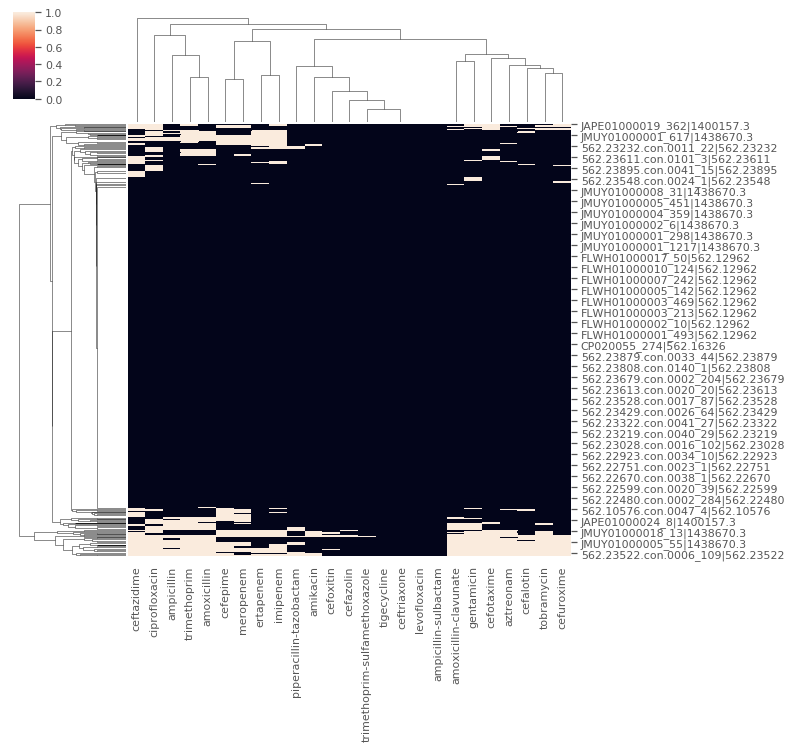

In [18]:
import seaborn as sns; sns.set(color_codes=True)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math
mpl.style.use("ggplot")
# plot inline
%matplotlib inline
import numpy as np
g = sns.clustermap(genotype_reject_fisher.fillna(False))

In [19]:
genotype_odds.head()

,levofloxacin,cefazolin,ampicillin-sulbactam,ceftriaxone,trimethoprim-sulfamethoxazole,cefalotin,trimethoprim,cefoxitin,aztreonam,amikacin,...,amoxicillin,imipenem,tigecycline,cefotaxime,piperacillin-tazobactam,cefuroxime,amoxicillin-clavunate,ceftazidime,ciprofloxacin,gentamicin
562.10576.con.0008_20|562.10576,NaN,NaN,NaN,1.67797,NaN,3.25862,1.81944,1.99742,2.23214,4.04306,...,0.654545,6.39942,106.852,1.26731,0.916918,1.05439,0.455292,2.09524,0.846575,0.919507
562.10576.con.0029_46|562.10576,NaN,NaN,NaN,2.89474,1.32,NaN,5.45361,9.7,45.7229,8.95789,...,NaN,23.8696,321.222,45.0687,4.60469,NaN,NaN,63.4305,21.295,61.0515
562.10576.con.0045_7|562.10576,NaN,NaN,NaN,1.67797,NaN,NaN,NaN,NaN,26.7882,14.9649,...,1.96896,8.96735,321.222,2.96158,14.0204,1.7526,6.85761,12.6161,1.40886,36.3191
562.10576.con.0045_9|562.10576,NaN,NaN,NaN,1.67797,NaN,NaN,NaN,NaN,26.7882,14.9649,...,1.96896,8.96735,321.222,2.96158,14.0204,1.7526,6.85761,12.6161,1.40886,36.3191
562.10576.con.0047_4|562.10576,0.957447,2.56098,1.14545,2.89474,2.26027,NaN,5.45361,40.9474,45.7229,6.38346,...,3.28658,24.9091,106.852,9.02759,7.0051,1.05073,11.4541,19.2545,12.8276,37.0696


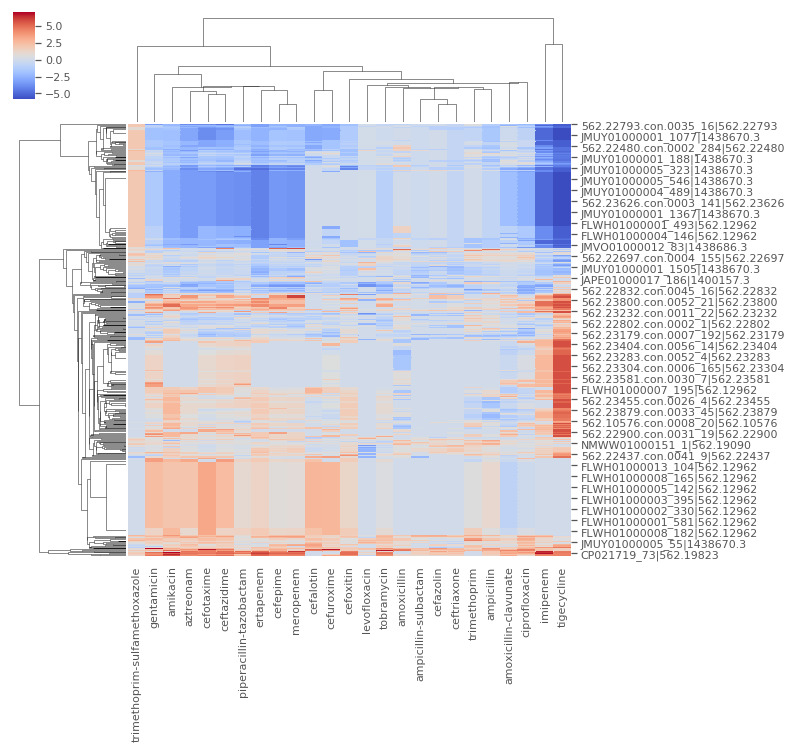

In [20]:
sns.clustermap(genotype_odds.replace(0,0.0001).fillna(1).applymap(math.log), cmap = 'coolwarm', method = 'centroid')

In [21]:
# ontotypes
ontotypes = ont2.get_ontotype(can_pan, input_format = 'matrix')

In [22]:
#ontotypes.to_csv('/home/hermuba/data0118/ontologies/ontotype.csv')

In [23]:
#v, v_reject = test_all_drug(drugs, ontotypes, pheno)

In [24]:
#sns.clustermap(v_reject.fillna(False))
# should be testing for association this is not right

In [31]:
# finding significant genes within candidates
def preprocessing_ontotype(df, ris, abx):
    y= ris[abx].dropna()
    X = df.loc[y.index]
    # unique values
    unique_value = pd.Series([True if len(X[col].unique())>1 else False for col in X.columns], index = X.columns)
   
    # at least one genome having that gene gaurentee it to worth examine
    X = X.loc[:,unique_value]

    return(X, y)

In [32]:
import numpy as np
from scipy.stats import pearsonr
def permute(X_col, y):

    np.random.shuffle(y)   
    true_pearson, discard_p = pearsonr(X_col,y)
    return(true_pearson)

def run_permutation_test_pearson(X_col,y):
    true_pearson, p = pearsonr(X_col,y)
    numSamples = 100
    estimates = np.array(list(map(lambda x: permute(X_col, y),range(numSamples)))) # 1000 samples
    
    diffCount = len(np.where(np.absolute(estimates) > np.absolute(true_pearson))[0])
    our_p = diffCount/numSamples
    return (true_pearson, our_p)

In [33]:
import scipy.stats as stats
def test_all_drug_pearson(drugs, df, ris):
    corr_p_values = pd.DataFrame(index = df.columns, columns = drugs) # index = genes, column = drug, value = uncorrected p value
    significant = pd.DataFrame(index = df.columns, columns = drugs)
    odds_df = pd.DataFrame(index = df.columns, columns = drugs)
    for d in drugs:
        print(d)
        X, y = preprocessing(df, ris, d)
        odds_list = []
        uncorrected_pvalues = []
        for column in X.columns: 
            pearson, p = run_permutation_test_pearson(X[column], y)
            odds_list.append(pearson)
            uncorrected_pvalues.append(p)
        rejected, p_corrected = fdrcorrection(uncorrected_pvalues, alpha=0.05)
        corr_p_values.loc[X.columns, d] = p_corrected
        significant.loc[X.columns, d] = rejected
        odds_df.loc[X.columns, d] = odds_list
    return(corr_p_values, significant, odds_df)

In [28]:
X,y = preprocessing(ontotypes, pheno, 'levofloxacin')

In [29]:
y.shape

(31,)

In [34]:
p_pearson, signi_pearson, pearson_df = test_all_drug_pearson(drugs, ontotypes, pheno)

levofloxacin
cefazolin
ampicillin-sulbactam
ceftriaxone
trimethoprim-sulfamethoxazole
cefalotin
trimethoprim
cefoxitin
aztreonam
amikacin
ertapenem
tobramycin
cefepime
ampicillin
meropenem
amoxicillin
imipenem
tigecycline
cefotaxime
piperacillin-tazobactam
cefuroxime
amoxicillin-clavunate
ceftazidime
ciprofloxacin
gentamicin


In [39]:
#p_pearson.to_csv('/home/hermuba/data0118/ontologies/ontotype_pearson_more.csv')
#signi_pearson.to_csv('/home/hermuba/data0118/ontologies/ontotype_pearson_reject_more.csv')
#pearson_df.to_csv('/home/hermuba/data0118/ontologies/ontotype_pearson_corr_more.csv')

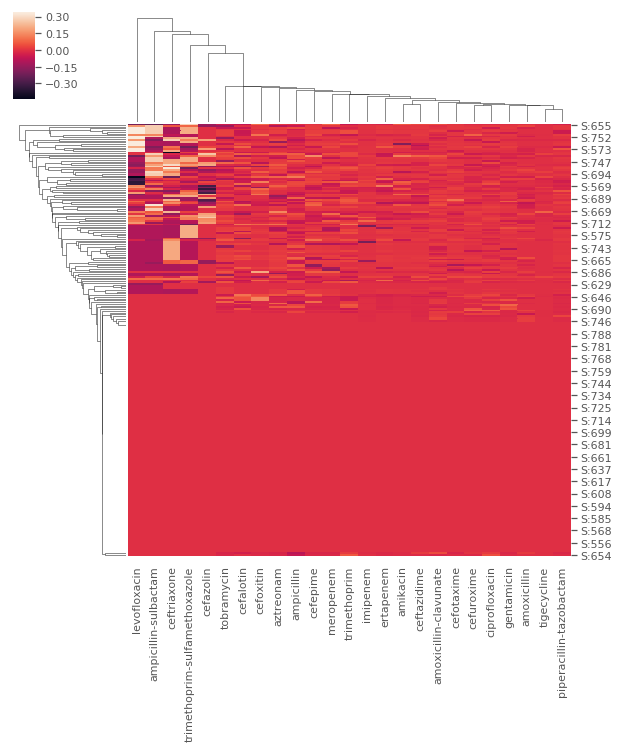

In [37]:
sns.clustermap(pearson_df.fillna(0))

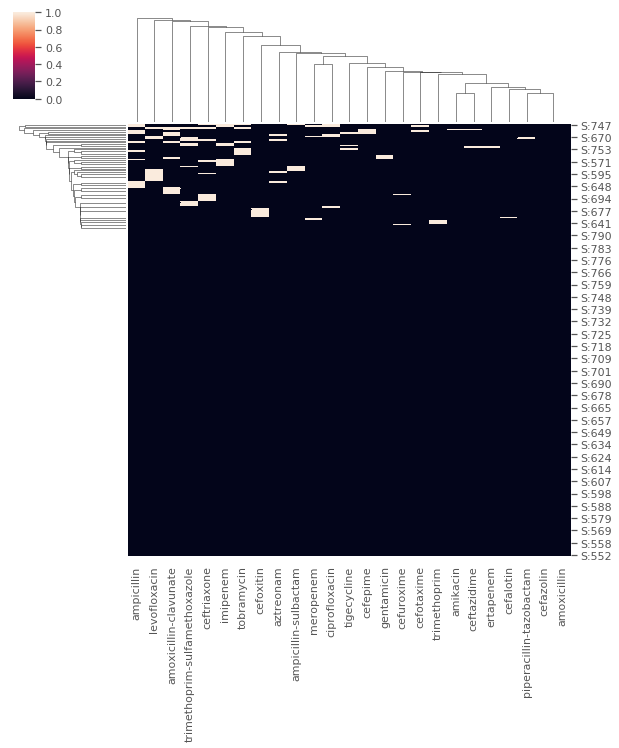

In [38]:
sns.clustermap(signi_pearson.fillna(False))